In [1]:
!pip install yfinance py2neo pandas numpy matplotlib plotly



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from neo4j import GraphDatabase

# Neo4j connection details
URI = "bolt://localhost:7687"  # Change if using remote Neo4j
USERNAME = "neo4j"
PASSWORD = "password"

# Create Neo4j Driver
driver = GraphDatabase.driver(URI, auth=(USERNAME, PASSWORD))

# Test Connection
def test_connection(tx):
    result = tx.run("RETURN 'Connected to Neo4j!' AS message")
    return result.single()["message"]

with driver.session() as session:
    message = session.execute_read(test_connection)
    print(message)  # Output: Connected to Neo4j!


Connected to Neo4j!


In [3]:
def create_transaction(tx, date, ticker, open_price, close_price, volume):
    query = """
    CREATE (t:Transaction {date: $date, ticker: $ticker, open: $open_price, close: $close_price, volume: $volume})
    RETURN t
    """
    tx.run(query, date=date, ticker=ticker, open_price=open_price, close_price=close_price, volume=volume)

# Example transaction data
sample_transaction = {
    "date": "2024-02-18",
    "ticker": "AAPL",
    "open_price": 177.83,
    "close_price": 182.00,
    "volume": 104487900
}

# Insert transaction into Neo4j
with driver.session() as session:
    session.execute_write(create_transaction, **sample_transaction)
print("Transaction stored in Neo4j!")


Transaction stored in Neo4j!


In [4]:
def fetch_transactions(tx):
    query = "MATCH (t:Transaction) RETURN t.date AS date, t.ticker AS ticker, t.open AS open_price, t.close AS close_price, t.volume AS volume LIMIT 5"
    result = tx.run(query)
    return [record for record in result]

with driver.session() as session:
    transactions = session.execute_read(fetch_transactions)

for t in transactions:
    print(t)


<Record date='2024-02-18' ticker='AAPL' open_price=177.83 close_price=182.0 volume=104487900>


In [5]:
driver.close()


In [6]:
def create_relationships(tx):
    # Create a NEXT relationship for consecutive transactions of the same ticker
    query = """
    MATCH (t1:Transaction), (t2:Transaction)
    WHERE t1.ticker = t2.ticker AND date(t1.date) = date(t2.date) - duration('P1D')
    MERGE (t1)-[:NEXT]->(t2)
    """
    tx.run(query)

    # Create a SIMILAR relationship for transactions with similar price trends
    query = """
    MATCH (t1:Transaction), (t2:Transaction)
    WHERE t1.ticker = t2.ticker AND abs(t1.close - t2.close) < 5
    MERGE (t1)-[:SIMILAR]->(t2)
    """
    tx.run(query)

# Execute relationship creation
with driver.session() as session:
    session.execute_write(create_relationships)

print("Relationships created!")


C:\Users\loksa\AppData\Local\Temp\ipykernel_2748\3698637067.py:19: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


Relationships created!


In [7]:
def mark_risky_transactions(tx):
    query = """
    MATCH (t:Transaction)
    WHERE t.volume > 100000000 OR t.close < (t.open * 0.9)
    SET t.risk = 'High'
    RETURN t.ticker, t.date, t.risk
    """
    result = tx.run(query)
    return [record for record in result]

# Execute risk labeling
with driver.session() as session:
    high_risk_transactions = session.execute_write(mark_risky_transactions)

print("High-risk transactions identified:", high_risk_transactions)


High-risk transactions identified: [<Record t.ticker='AAPL' t.date='2024-02-18' t.risk='High'>]


C:\Users\loksa\AppData\Local\Temp\ipykernel_2748\3918074032.py:12: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


C:\Users\loksa\AppData\Local\Temp\ipykernel_2748\892590003.py:14: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


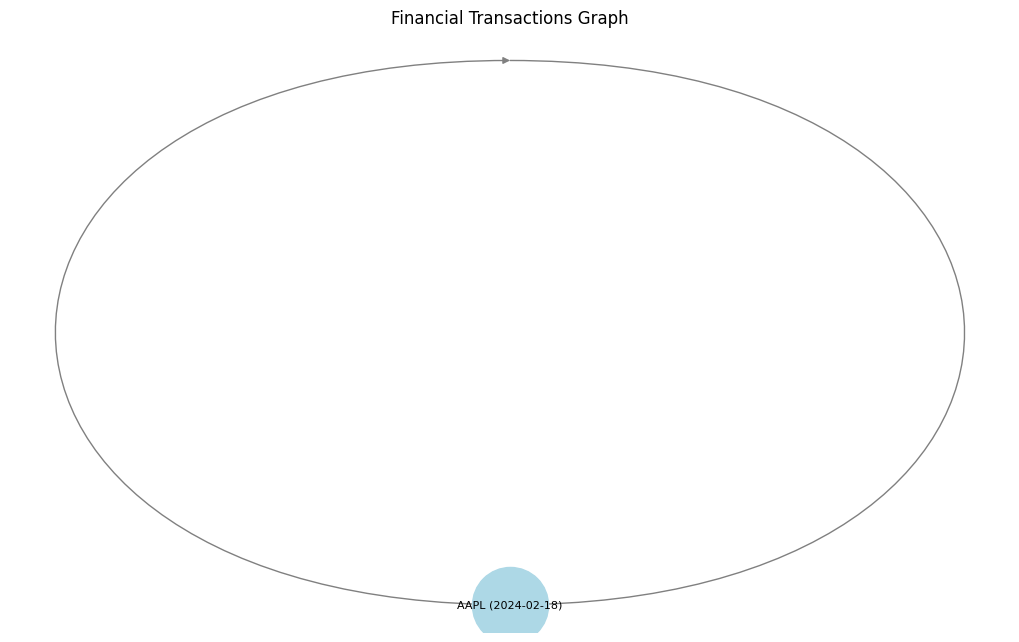

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

def fetch_graph_data(tx):
    query = """
    MATCH (t1:Transaction)-[r]->(t2:Transaction)
    RETURN t1.ticker AS from_ticker, t1.date AS from_date, 
           t2.ticker AS to_ticker, t2.date AS to_date, 
           type(r) AS relation
    """
    result = tx.run(query)
    return [record for record in result]

with driver.session() as session:
    edges = session.execute_read(fetch_graph_data)

# Create a Graph using NetworkX
G = nx.DiGraph()

for edge in edges:
    G.add_edge(f"{edge['from_ticker']} ({edge['from_date']})", 
               f"{edge['to_ticker']} ({edge['to_date']})", 
               relation=edge["relation"])

# Draw the Graph
plt.figure(figsize=(10, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', font_size=8, node_size=3000)
plt.title("Financial Transactions Graph")
plt.show()
